In [28]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("24120901_sf_fire_calls_App").getOrCreate()


In [29]:
df = spark.read.format('csv').load('data/sf-fire-calls.csv', inferSchema=True, header=True)

In [30]:
df.schema

StructType(List(StructField(CallNumber,IntegerType,true),StructField(UnitID,StringType,true),StructField(IncidentNumber,IntegerType,true),StructField(CallType,StringType,true),StructField(CallDate,StringType,true),StructField(WatchDate,StringType,true),StructField(CallFinalDisposition,StringType,true),StructField(AvailableDtTm,StringType,true),StructField(Address,StringType,true),StructField(City,StringType,true),StructField(Zipcode,IntegerType,true),StructField(Battalion,StringType,true),StructField(StationArea,StringType,true),StructField(Box,StringType,true),StructField(OriginalPriority,StringType,true),StructField(Priority,StringType,true),StructField(FinalPriority,IntegerType,true),StructField(ALSUnit,BooleanType,true),StructField(CallTypeGroup,StringType,true),StructField(NumAlarms,IntegerType,true),StructField(UnitType,StringType,true),StructField(UnitSequenceInCallDispatch,IntegerType,true),StructField(FirePreventionDistrict,StringType,true),StructField(SupervisorDistrict,Strin

In [31]:
#호출 유형별 빈도수 계산

In [32]:
from pyspark.sql.functions import count

call_type_counts = df.groupBy("CallType").agg(count("*").alias("count"))
call_type_counts.orderBy("count", ascending=False).show()


+--------------------+------+
|            CallType| count|
+--------------------+------+
|    Medical Incident|113794|
|      Structure Fire| 23319|
|              Alarms| 19406|
|   Traffic Collision|  7013|
|Citizen Assist / ...|  2524|
|               Other|  2166|
|        Outside Fire|  2094|
|        Vehicle Fire|   854|
|Gas Leak (Natural...|   764|
|        Water Rescue|   755|
|Odor (Strange / U...|   490|
|   Electrical Hazard|   482|
|Elevator / Escala...|   453|
|Smoke Investigati...|   391|
|          Fuel Spill|   193|
|              HazMat|   124|
|Industrial Accidents|    94|
|           Explosion|    89|
|Train / Rail Inci...|    57|
|  Aircraft Emergency|    36|
+--------------------+------+
only showing top 20 rows



In [33]:
from pyspark.sql.functions import count

# 가장 흔한 형태의 신고(CallType)를 계산
most_common_call = df.groupBy("CallType").agg(count("*").alias("count")) \
                     .orderBy("count", ascending=False)


most_common_call.show(10)  


+--------------------+------+
|            CallType| count|
+--------------------+------+
|    Medical Incident|113794|
|      Structure Fire| 23319|
|              Alarms| 19406|
|   Traffic Collision|  7013|
|Citizen Assist / ...|  2524|
|               Other|  2166|
|        Outside Fire|  2094|
|        Vehicle Fire|   854|
|Gas Leak (Natural...|   764|
|        Water Rescue|   755|
+--------------------+------+
only showing top 10 rows



In [15]:
#2018년에 왔던 신고 전화들의 모든 유형은 어떤 것이 있었는가?

from pyspark.sql.functions import year
from pyspark.sql.functions import to_date

# CallDate를 날짜 형식으로 변환
df = df.withColumn("CallDate", to_date("CallDate", "MM/dd/yyyy"))

# 2018년에 발생한 모든 신고 유형(CallType)을 추출
calls_2018 = df.filter(year(df["CallDate"]) == 2018).select("CallType").distinct()

# 결과 확인
calls_2018.show(truncate=False)  # 신고 유형 출력



+-------------------------------+
|CallType                       |
+-------------------------------+
|Elevator / Escalator Rescue    |
|Alarms                         |
|Odor (Strange / Unknown)       |
|Citizen Assist / Service Call  |
|HazMat                         |
|Explosion                      |
|Vehicle Fire                   |
|Suspicious Package             |
|Other                          |
|Outside Fire                   |
|Traffic Collision              |
|Assist Police                  |
|Gas Leak (Natural and LP Gases)|
|Water Rescue                   |
|Electrical Hazard              |
|Structure Fire                 |
|Medical Incident               |
|Fuel Spill                     |
|Smoke Investigation (Outside)  |
|Train / Rail Incident          |
+-------------------------------+



In [34]:
#2018년도에 신고 전화가 가장 많았던 달은 언제인가?
from pyspark.sql.functions import month, count

# CallDate를 날짜 형식으로 변환 (이미 변환되었는지 확인 필요)
df = df.withColumn("CallDate", to_date("CallDate", "MM/dd/yyyy"))

# 2018년 데이터 필터링
calls_2018 = df.filter(year(df["CallDate"]) == 2018)

# 월별 신고 전화 수 계산
calls_by_month = calls_2018.groupBy(month("CallDate").alias("Month")) \
    .agg(count("*").alias("TotalCalls")) \
    .orderBy("TotalCalls", ascending=False)

# 결과 확인
calls_by_month.show(5)  # 가장 많은 신고 전화가 있었던 달 5개 출력




+-----+----------+
|Month|TotalCalls|
+-----+----------+
|   10|      1068|
|    5|      1047|
|    3|      1029|
|    8|      1021|
|    1|      1007|
+-----+----------+
only showing top 5 rows



In [35]:
#2018년도에 가장 많은 신고가 들어온 샌프란시스코 지역은 어디인가?

from pyspark.sql.functions import count

# 2018년 데이터 필터링
calls_2018 = df.filter(year(df["CallDate"]) == 2018)

# 지역(Neighborhood)별 신고 건수 계산
calls_by_neighborhood = calls_2018.groupBy("Neighborhood") \
    .agg(count("*").alias("TotalCalls")) \
    .orderBy("TotalCalls", ascending=False)

# 가장 많은 신고가 들어온 지역 10개 출력
calls_by_neighborhood.show(10)




+--------------------+----------+
|        Neighborhood|TotalCalls|
+--------------------+----------+
|          Tenderloin|      1393|
|     South of Market|      1053|
|             Mission|       913|
|Financial Distric...|       772|
|Bayview Hunters P...|       522|
|    Western Addition|       352|
|     Sunset/Parkside|       346|
|            Nob Hill|       295|
|        Hayes Valley|       291|
|      Outer Richmond|       262|
+--------------------+----------+
only showing top 10 rows



In [18]:
#2018년도 가장 응답시간이 늦었던 지역은 어디일까?
from pyspark.sql.functions import avg

# 2018년 데이터 필터링
calls_2018 = df.filter(year(df["CallDate"]) == 2018)

# 지역(Neighborhood)별 평균 응답 시간 계산
slowest_response = calls_2018.groupBy("Neighborhood") \
    .agg(avg("Delay").alias("AvgResponseDelay")) \
    .orderBy("AvgResponseDelay", ascending=False)

# 가장 응답 시간이 늦었던 지역 출력
slowest_response.show(10)



+--------------------+------------------+
|        Neighborhood|  AvgResponseDelay|
+--------------------+------------------+
|           Chinatown|6.1903140979057625|
|            Presidio| 5.829227041449275|
|     Treasure Island| 5.453703712499999|
|        McLaren Park| 4.744047642857142|
|Bayview Hunters P...|4.6205619568773955|
|    Presidio Heights| 4.594131472394366|
|        Inner Sunset| 4.438095199935065|
|      Inner Richmond| 4.364728682713178|
|Financial Distric...| 4.344084618290155|
|      Haight Ashbury| 4.266428599285713|
+--------------------+------------------+
only showing top 10 rows



In [36]:
#2018년에 어떤 주에서 가장 신고가 많았는가??
from pyspark.sql.functions import count

# 2018년 데이터 필터링
calls_2018 = df.filter(year(df["CallDate"]) == 2018)

# 주(City)별 신고 건수 계산
calls_by_state = calls_2018.groupBy("City") \
    .agg(count("*").alias("TotalCalls")) \
    .orderBy("TotalCalls", ascending=False)

# 신고가 가장 많았던 주(City) 출력
calls_by_state.show(10)




+-------------+----------+
|         City|TotalCalls|
+-------------+----------+
|San Francisco|      9967|
|     Presidio|        63|
|Treasure Isla|        58|
|         null|        19|
|  Yerba Buena|        10|
|Hunters Point|         9|
|   Fort Mason|         8|
|     Brisbane|         1|
|    Daly City|         1|
+-------------+----------+



In [37]:
#지역, 우편번호, 신고 숫자 간에 상관관계가 있는가?

from pyspark.sql.functions import corr

# Zipcode와 Delay 간의 상관관계 계산
zipcode_correlation = df.select(corr("Zipcode", "Delay").alias("Correlation"))

# 결과 출력
zipcode_correlation.show()


+--------------------+
|         Correlation|
+--------------------+
|0.013593185456683806|
+--------------------+



gpt한테 물어봄 _ 결과는 상관계수(Correlation Coefficient)로 반환
1에 가까울수록 강한 양의 상관관계.
-1에 가까울수록 강한 음의 상관관계.
0에 가까울수록 상관관계 없음.

코드 상세 설명
corr("Zipcode", "Delay"):

corr는 **상관계수(Correlation Coefficient)**를 계산하는 PySpark의 함수입니다.
"Zipcode": 우편번호(지역) 열.
"Delay": 신고 지연 시간 열.
이 함수는 두 열 간의 상관계수를 계산합니다.
결과값은 -1에서 1 사이의 실수로 반환됩니다:

1: 강한 양의 상관관계 (두 값이 함께 증가).
0: 상관관계 없음.
-1: 강한 음의 상관관계 (한 값이 증가하면 다른 값이 감소).
.select(corr(...).alias("Correlation")):

corr로 계산된 상관계수 값을 새 컬럼 Correlation에 저장합니다.
.alias("Correlation"): 계산된 상관계수에 별칭을 부여하여 DataFrame 컬럼 이름으로 사용.
.show():

DataFrame의 결과를 출력합니다.
계산된 상관계수를 화면에 표시합니다.

In [20]:
# 데이터를 Parquet 파일로 저장
df.write.format("parquet").save("data/sf_fire_calls.parquet")


In [21]:
spark.stop()

In [38]:
#시각화..??

In [40]:
pip install pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 176.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


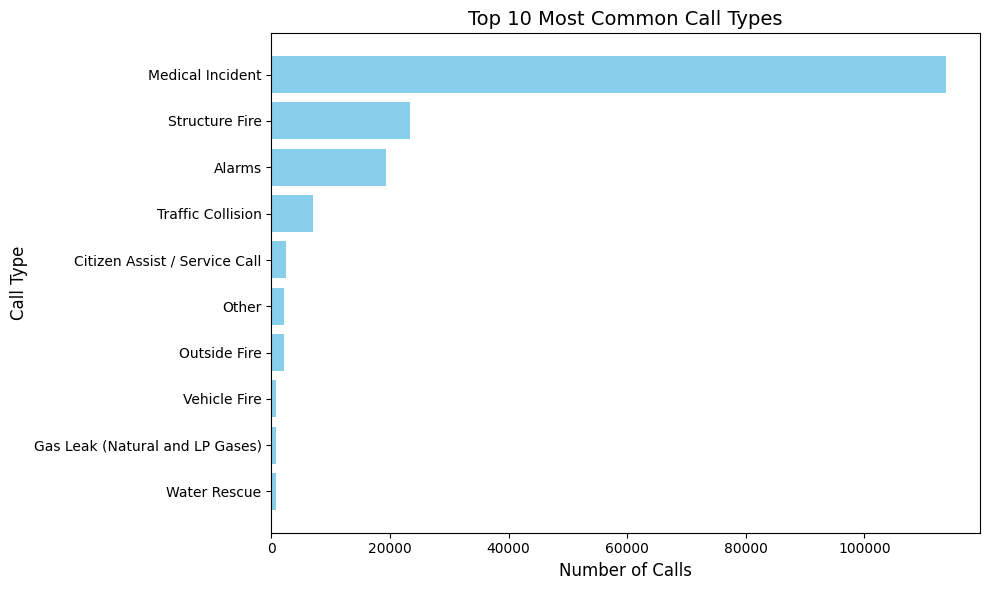

In [43]:
import matplotlib.pyplot as plt

# PySpark 데이터프레임을 Pandas로 변환
most_common_call_pandas = most_common_call.toPandas()


# Top 10 신고 유형만 선택
top_10_calls = most_common_call.limit(10).toPandas()

# 신고 유형(CallType)별 빈도수 시각화
plt.figure(figsize=(10, 6))
plt.barh(top_10_calls["CallType"], top_10_calls["count"], color="skyblue")
plt.xlabel("Number of Calls", fontsize=12)
plt.ylabel("Call Type", fontsize=12)
plt.title("Top 10 Most Common Call Types", fontsize=14)
plt.gca().invert_yaxis()  # 막대 그래프를 위에서 아래로 정렬
plt.tight_layout()
plt.show()

